In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
print tf.__version__

/opt/conda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.9.0


# Fundamentos de TensorFlow

**Expresiones**
- Las expresiones son construidas en términos de **variables** (para los parémetros, como $\theta$) y **placeholders** (para los datos)

- Cuando definimos las expresiones **construimos su grafo simbólico**, pero **no son evaluadas**

- Las expresiones sólo son evaluadas **dentro de una sesión**

- El proceso de **optimización** trata de encontrar valores de las **variables** que minimizan una cierta expresión. 


**Parámetros**
- Las **variables** tienen un tamaño fijo, contienen los parámetros de un modelos, que luego pueden ser salvados o restaurados.

- Las **variables** pueden tener un valor constante, pero normalmente se inicializan con algún valor aleatorio o determinado, y su contenido va variando durante el proceso de optimización.

**Datos**
- Los **placeholders** pueden ser matrices (tensores) con un número fijo de columnas, pero variable de filas, para poder evaluar las expresiones con distintos datasets.

- Los **placeholders** no tienen valores iniciales, y hay que alimentarlos directamente con los datos



**Gradientes**

- TensorFlow calcula automáticamente los gradientes de las expresiones, que los obtiene simbólicamente. Normalmente los gradientes se calculan **respecto a los parámetros** (_placeholders_)

## TensorFlow: cálculo simbólico para ML

fíjate cómo en TF se define un grafo (simbólico) y luego se le inyectan valores para evaluarlo


In [2]:
tf.reset_default_graph()
x = tf.Variable(initial_value=tf.random_normal([1]), name="x", dtype=tf.float32)
y = tf.Variable(initial_value=tf.random_normal([1]), name="y", dtype=tf.float32)
f = x**2+y**2
f

<tf.Tensor 'add:0' shape=(1,) dtype=float32>

In [3]:
dx = tf.gradients(f, x)
dy = tf.gradients(f, y)


In [4]:
val_x, val_y = 5, 2
with tf.Session() as sess:
    val_f, val_dx, val_dy = sess.run([f, dx, dy], feed_dict={x: [val_x], y:[val_y]})
print " f(%d,%d) = %d"%(val_x, val_y, val_f)
print "dx(%d,%d) = %d"%(val_x, val_y, val_dx[0])
print "dy(%d,%d) = %d"%(val_x, val_y, val_dy[0])

 f(5,2) = 29
dx(5,2) = 10
dy(5,2) = 4


In [5]:
!rm -rf tmp
with tf.Session() as sess:
    writer = tf.summary.FileWriter("tmp", sess.graph)


ejecuta

     tensorboard --logdir tmp
    
desde la línea de comando y abre [localhost:6006](http://localhost:6006) para inspeccionar el **grafo computacional** que representa la expresión anterior

## Single Layer Perceptron

$$\hat{y} = \text{sigmoid}(\mathbf{W}_2 \cdot \tanh(\mathbf{x^T} \cdot \mathbf{W}_1 + \mathbf{b}_1) + b_2)$$

$$J(\mathbf{b}_1, b_2, \mathbf{W}_1, \mathbf{W}_2) = \frac{1}{m}\sum_{i=0}^{m-1} (\hat{y}-y)^2 $$


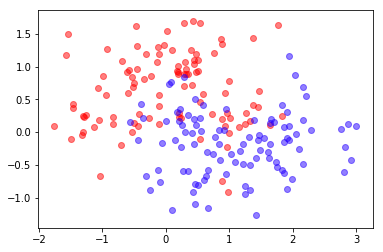

In [6]:
from sklearn.datasets import make_moons
import mlutils
X,y = make_moons(200,noise=.4)
mlutils.plot_2Ddata(X,y)

### Parámetros de entrada

In [55]:
input_units  = 2
h_units      = 5
output_units = 1

### Grafo computacional

In [56]:
tf.reset_default_graph()

# symbolic vars for model parameters
tW1 = tf.Variable(initial_value=tf.random_uniform([input_units, h_units], dtype=tf.float64), name="W1", dtype=tf.float64)
tb1 = tf.Variable(initial_value=tf.random_uniform([h_units], dtype=tf.float64), name="b1", dtype=tf.float64)
tW2 = tf.Variable(initial_value=tf.random_uniform([h_units, output_units], dtype=tf.float64), name="W2", dtype=tf.float64)
tb2 = tf.Variable(initial_value=tf.random_uniform([output_units], dtype=tf.float64), name="b2", dtype=tf.float64)

# symbolic vars for data
tX = tf.placeholder(name="X", dtype=tf.float64, shape = (None, input_units))
ty = tf.placeholder(name="y", dtype=tf.float64, shape = (None, output_units))


In [57]:
print tW1.shape
print tW2.shape
print tb1.shape
print tb2.shape


(2, 5)
(5, 1)
(5,)
(1,)


In [58]:
y_hat = tf.sigmoid(tf.matmul(tf.tanh(tf.matmul(tX,tW1)+tb1), tW2) + tb2)
loss = tf.reduce_mean(tf.pow((y_hat - ty),2))             

### Optimización

In [63]:
optimizer_gd = tf.train.GradientDescentOptimizer(.5).minimize(loss)

init = tf.global_variables_initializer()

loss_hist = []
steps = 3000

with tf.Session() as sess:
    sess.run(init)
    
    for i in mlutils.pbar()(xrange(1,steps)):
        # parameter update
        sess.run(optimizer_gd, feed_dict={tX: X, ty: y.reshape(-1,1)})
        # history
        if i%10==0:
            loss_val = sess.run(loss, feed_dict={tX: X, ty: y.reshape(-1,1)})
            loss_hist.append(loss_val)
        
    val_W1, val_W2, val_b1, val_b2 = sess.run([tW1, tW2, tb1, tb2])

100% (2999 of 2999) |####################| Elapsed Time: 0:00:05 Time:  0:00:05


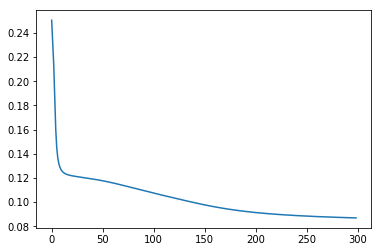

In [64]:
plt.plot(loss_hist)

### Predicción

In [65]:
def predict(X):
    with tf.Session() as sess:
        preds = sess.run(y_hat, feed_dict={tX: X,  
                                           tW1: val_W1, tW2: val_W2, tb1: val_b1, tb2: val_b2})
    return (preds[:,0]>.5).astype(int)

(0.4718, 0.5282)

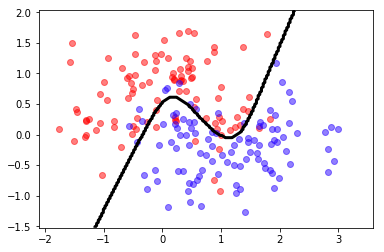

In [67]:
mlutils.plot_2Ddata_with_boundary(predict, X, y)